# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [50]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image as PILImage
from pycocotools import mask as maskUtils
# 设置根目录，上上层
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from pycocotools.coco import COCO
import json
%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = "E:\Mask_RCNN\samples\mask_rcnn_coco.h5"
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [51]:
class OralConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "Oral"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 3

    # Number of classes (including background)
    NUM_CLASSES = 1 + 7  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 480
    IMAGE_MAX_DIM = 640

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = OralConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     3
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 3
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                20
IMAGE_MIN_DIM                  480
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [52]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [53]:
class OralDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("oral", 1, "teeth_top")
        self.add_class("oral", 2, "teeth_bottom")
        self.add_class("oral", 3, "uvula")
        self.add_class("oral", 4, "tongue")
        self.add_class("oral", 5, "pp_wall")
        self.add_class("oral", 6, "tonsil_right")
        self.add_class("oral", 7, "tonsil_left")
        anns_json_path =  'E:\\Mask_RCNN\\oral_test\\annotations.json'
        with open(anns_json_path,'r',encoding='utf8') as load_f:
            config_json = json.load(load_f)
            img_path = 'E:\\Mask_RCNN\\oral_test\\'
            coco = COCO(anns_json_path)
            class_ids = sorted(coco.getCatIds())
            for i in range(6):
                self.add_image("oral", image_id=i, path=img_path + config_json['images'][i]['file_name'],
                           width=640, height=480, annotations=coco.loadAnns(coco.getAnnIds(imgIds=[i], catIds=class_ids, iscrowd=None)))

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        image = PILImage.open(info['path'])
        image = np.array(image).astype(np.uint8)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        if image_info["source"] != "oral":
            return super(OralDataset, self).load_mask(image_id)

        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["annotations"]
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = self.map_source_class_id("oral.{}".format(annotation['category_id']))
            if class_id:
                m = self.annToMask(annotation, image_info["height"],
                                   image_info["width"])
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue
                # Is it a crowd? If so, use a negative class ID.
                if annotation['iscrowd']:
                    # Use negative class ID for crowds
                    class_id *= -1
                    # For crowd masks, annToMask() sometimes returns a mask
                    # smaller than the given dimensions. If so, resize it.
                    if m.shape[0] != image_info["height"] or m.shape[1] != image_info["width"]:
                        m = np.ones([image_info["height"], image_info["width"]], dtype=bool)
                instance_masks.append(m)
                class_ids.append(class_id)

        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2).astype(np.bool)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        else:
            # Call super class to return an empty mask
            return super(OralDataset, self).load_mask(image_id)

    # annotation convert to RLE
    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentation']
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle

    # annotation 转mask
    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [54]:
# Training dataset
dataset_train = OralDataset()
dataset_train.load_shapes()
dataset_train.prepare()

# Validation dataset
dataset_val = OralDataset()
dataset_val.load_shapes()
dataset_val.prepare()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


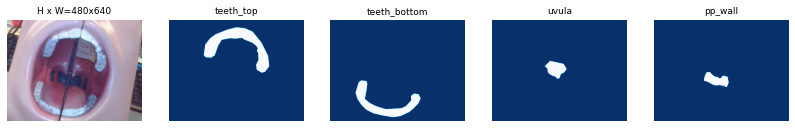

In [55]:
# Load and display random samples
# image_ids = np.random.choice(dataset_train.image_ids, 4)
image = dataset_train.load_image(0)
mask, class_ids = dataset_train.load_mask(0)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [56]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [57]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [58]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=40,
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: E:\Mask_RCNN\logs\oral20200509T0205\mask_rcnn_oral_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         

e:\programdata\miniconda3\envs\maskrcnn\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/40
100/100 [==============================] - 101s 1s/step - loss: 2.0612 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.8115 - mrcnn_class_loss: 0.3018 - mrcnn_bbox_loss: 0.3341 - mrcnn_mask_loss: 0.5861 - val_loss: 0.8504 - val_rpn_class_loss: 0.0124 - val_rpn_bbox_loss: 0.1743 - val_mrcnn_class_loss: 0.1214 - val_mrcnn_bbox_loss: 0.1071 - val_mrcnn_mask_loss: 0.4352
Epoch 2/40
100/100 [==============================] - 96s 958ms/step - loss: 0.5979 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0983 - mrcnn_class_loss: 0.0781 - mrcnn_bbox_loss: 0.0727 - mrcnn_mask_loss: 0.3389 - val_loss: 0.4162 - val_rpn_class_loss: 0.0078 - val_rpn_bbox_loss: 0.0541 - val_mrcnn_class_loss: 0.0750 - val_mrcnn_bbox_loss: 0.0512 - val_mrcnn_mask_loss: 0.2279
Epoch 3/40
100/100 [==============================] - 97s 969ms/step - loss: 0.3136 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0318 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.1786 - val_loss: 0.2662 - val_rpn_cla

Epoch 23/40
100/100 [==============================] - 104s 1s/step - loss: 0.0675 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0019 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0068 - mrcnn_mask_loss: 0.0404 - val_loss: 0.0661 - val_rpn_class_loss: 0.0018 - val_rpn_bbox_loss: 7.6460e-04 - val_mrcnn_class_loss: 0.0165 - val_mrcnn_bbox_loss: 0.0053 - val_mrcnn_mask_loss: 0.0417
Epoch 24/40
100/100 [==============================] - 105s 1s/step - loss: 0.0584 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0012 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0379 - val_loss: 0.0571 - val_rpn_class_loss: 0.0016 - val_rpn_bbox_loss: 6.0096e-04 - val_mrcnn_class_loss: 0.0134 - val_mrcnn_bbox_loss: 0.0040 - val_mrcnn_mask_loss: 0.0376
Epoch 25/40
100/100 [==============================] - 105s 1s/step - loss: 0.0628 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0012 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0386 - val_loss: 0.0503 - val_

In [59]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=160,
            layers="all")


Starting at epoch 40. LR=0.0001

Checkpoint Path: E:\Mask_RCNN\logs\oral20200509T0205\mask_rcnn_oral_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b        

e:\programdata\miniconda3\envs\maskrcnn\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 41/160
100/100 [==============================] - 157s 2s/step - loss: 0.0453 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0018 - mrcnn_class_loss: 0.0086 - mrcnn_bbox_loss: 0.0027 - mrcnn_mask_loss: 0.0311 - val_loss: 0.0582 - val_rpn_class_loss: 8.3143e-04 - val_rpn_bbox_loss: 0.0015 - val_mrcnn_class_loss: 0.0210 - val_mrcnn_bbox_loss: 0.0033 - val_mrcnn_mask_loss: 0.0315
Epoch 42/160
100/100 [==============================] - 143s 1s/step - loss: 0.0493 - rpn_class_loss: 8.7021e-04 - rpn_bbox_loss: 0.0018 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.0315 - val_loss: 0.0426 - val_rpn_class_loss: 5.2157e-04 - val_rpn_bbox_loss: 0.0015 - val_mrcnn_class_loss: 0.0052 - val_mrcnn_bbox_loss: 0.0028 - val_mrcnn_mask_loss: 0.0325
Epoch 43/160
100/100 [==============================] - 140s 1s/step - loss: 0.0508 - rpn_class_loss: 9.3617e-04 - rpn_bbox_loss: 0.0018 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.0312 - val_loss: 0.

Epoch 62/160
100/100 [==============================] - 144s 1s/step - loss: 0.0357 - rpn_class_loss: 9.3081e-04 - rpn_bbox_loss: 5.3445e-04 - mrcnn_class_loss: 0.0053 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0279 - val_loss: 0.0350 - val_rpn_class_loss: 3.2709e-04 - val_rpn_bbox_loss: 7.8254e-04 - val_mrcnn_class_loss: 0.0056 - val_mrcnn_bbox_loss: 9.8723e-04 - val_mrcnn_mask_loss: 0.0273
Epoch 63/160
100/100 [==============================] - 144s 1s/step - loss: 0.0373 - rpn_class_loss: 8.8162e-04 - rpn_bbox_loss: 6.6722e-04 - mrcnn_class_loss: 0.0055 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.0287 - val_loss: 0.0323 - val_rpn_class_loss: 6.7115e-04 - val_rpn_bbox_loss: 5.3366e-04 - val_mrcnn_class_loss: 0.0014 - val_mrcnn_bbox_loss: 0.0015 - val_mrcnn_mask_loss: 0.0282
Epoch 64/160
100/100 [==============================] - 144s 1s/step - loss: 0.0357 - rpn_class_loss: 9.1651e-04 - rpn_bbox_loss: 5.5561e-04 - mrcnn_class_loss: 0.0047 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask

100/100 [==============================] - 144s 1s/step - loss: 0.0341 - rpn_class_loss: 7.0410e-04 - rpn_bbox_loss: 4.2625e-04 - mrcnn_class_loss: 0.0042 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.0277 - val_loss: 0.0412 - val_rpn_class_loss: 4.0250e-04 - val_rpn_bbox_loss: 4.2664e-04 - val_mrcnn_class_loss: 0.0095 - val_mrcnn_bbox_loss: 0.0011 - val_mrcnn_mask_loss: 0.0297
Epoch 83/160
100/100 [==============================] - 144s 1s/step - loss: 0.0337 - rpn_class_loss: 6.6079e-04 - rpn_bbox_loss: 4.2139e-04 - mrcnn_class_loss: 0.0043 - mrcnn_bbox_loss: 9.6108e-04 - mrcnn_mask_loss: 0.0274 - val_loss: 0.0291 - val_rpn_class_loss: 3.7898e-04 - val_rpn_bbox_loss: 2.1587e-04 - val_mrcnn_class_loss: 6.1295e-04 - val_mrcnn_bbox_loss: 7.4888e-04 - val_mrcnn_mask_loss: 0.0272
Epoch 84/160
100/100 [==============================] - 144s 1s/step - loss: 0.0349 - rpn_class_loss: 7.9021e-04 - rpn_bbox_loss: 3.9683e-04 - mrcnn_class_loss: 0.0060 - mrcnn_bbox_loss: 8.1380e-04 - mrcnn_mask_

Epoch 103/160
100/100 [==============================] - 143s 1s/step - loss: 0.0327 - rpn_class_loss: 7.6932e-04 - rpn_bbox_loss: 4.3797e-04 - mrcnn_class_loss: 0.0050 - mrcnn_bbox_loss: 7.7999e-04 - mrcnn_mask_loss: 0.0257 - val_loss: 0.0340 - val_rpn_class_loss: 4.7111e-04 - val_rpn_bbox_loss: 2.0457e-04 - val_mrcnn_class_loss: 0.0067 - val_mrcnn_bbox_loss: 6.9601e-04 - val_mrcnn_mask_loss: 0.0259
Epoch 104/160
100/100 [==============================] - 142s 1s/step - loss: 0.0329 - rpn_class_loss: 5.7248e-04 - rpn_bbox_loss: 3.9075e-04 - mrcnn_class_loss: 0.0049 - mrcnn_bbox_loss: 0.0011 - mrcnn_mask_loss: 0.0259 - val_loss: 0.0336 - val_rpn_class_loss: 4.0805e-04 - val_rpn_bbox_loss: 2.9055e-04 - val_mrcnn_class_loss: 0.0057 - val_mrcnn_bbox_loss: 0.0012 - val_mrcnn_mask_loss: 0.0260
Epoch 105/160
100/100 [==============================] - 142s 1s/step - loss: 0.0291 - rpn_class_loss: 8.1309e-04 - rpn_bbox_loss: 3.0087e-04 - mrcnn_class_loss: 0.0022 - mrcnn_bbox_loss: 8.1539e-04 -

KeyboardInterrupt: 

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [60]:
class InferenceConfig(OralConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  E:\Mask_RCNN\logs\oral20200509T0205\mask_rcnn_oral_0118.h5
Re-starting from epoch 118


original_image           shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (20,)                 min:    0.00000  max:  640.00000  int32
gt_class_id              shape: (7,)                  min:    1.00000  max:    7.00000  int32
gt_bbox                  shape: (7, 4)                min:  165.00000  max:  470.00000  int32
gt_mask                  shape: (640, 640, 7)         min:    0.00000  max:    1.00000  bool
-----class_ids------
[2 1 4 6 7 5 3]
class_id:2
i:0
-----------
-----class_ids------
[2 1 4 6 7 5 3]
class_id:1
i:1
-----------
-----class_ids------
[2 1 4 6 7 5 3]
class_id:4
i:2
-----------
-----class_ids------
[2 1 4 6 7 5 3]
class_id:6
i:3
-----------
-----class_ids------
[2 1 4 6 7 5 3]
class_id:7
i:4
-----------
-----class_ids------
[2 1 4 6 7 5 3]
class_id:5
i:5
-----------
-----class_ids------
[2 1 4 6 7 5 3]
class_id:3
i:6
-----------


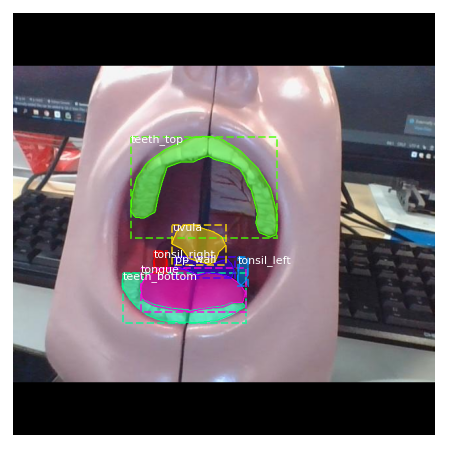

In [65]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max:  640.00000  int32
anchors                  shape: (1, 102300, 4)        min:   -0.14164  max:    1.04149  float32
----------r['class_ids']----------
[4 1 2 3 5 6 7]
----------r['class_ids']----------
-----class_ids------
[4 1 2 3 5 6 7]
class_id:4
i:0
-----------
-----class_ids------
[4 1 2 3 5 6 7]
class_id:1
i:1
-----------
-----class_ids------
[4 1 2 3 5 6 7]
class_id:2
i:2
-----------
-----class_ids------
[4 1 2 3 5 6 7]
class_id:3
i:3
-----------
-----class_ids------
[4 1 2 3 5 6 7]
class_id:5
i:4
-----------
-----class_ids------
[4 1 2 3 5 6 7]
class_id:6
i:5
-----------
-----class_ids------
[4 1 2 3 5 6 7]
class_id:7
i:6
-----------


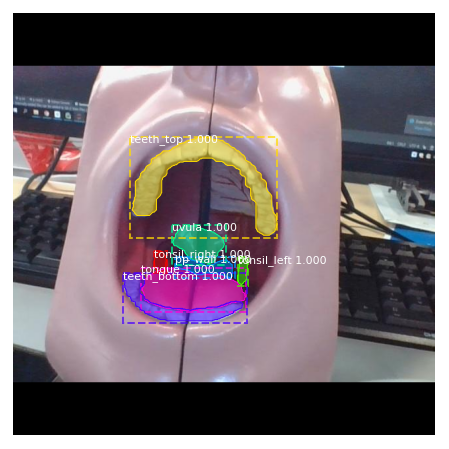

In [66]:
results = model.detect([original_image], verbose=1)

r = results[0]
print("----------r['class_ids']----------")
print(r['class_ids'])
print("----------r['class_ids']----------")
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [67]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  1.0
